In [1]:
import requests
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import json
import tensorflow as tf
import os
from my_datasets import TestTokenizer
from models.end_to_end_model import End2EndAspectSentimentModel
from utils.eval_utils import Result
from label_mappings import RES1516_LABEL_MAPPING, CATEGORY_LABEL_MAPPING, SENTIMENT_LABEL_MAPPING
from transformers import AutoTokenizer
from label_mappings import *
matplotlib.rcParams['axes.unicode_minus']=False
# matplotlib.rcParams['font.sans-serif'] = ['FangSong']

%matplotlib inline
url = "http://127.0.0.1:3030/absa_service"

/usr/local/miniconda3/envs/tf-2.8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mask_sb = True
model_type = "end_to_end"
# model_name = 'FacebookAI/roberta-base'
# model_name="microsoft/deberta-v3-base"
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=f'bert_models/{os.path.basename(model_name)}')
test_tokenizer = TestTokenizer(tokenizer, RES1516_LABEL_MAPPING , mask_sb, model_type)

In [3]:
# context = [
#     # "the product is great, but the customer support is horrible"
#      "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
# ]
# test_tokenizer.tokenize(context, aspect_texts=None)

In [3]:

# model_checkpoint = "checkpoint/ttee_pretrain_db_amazon_less_pos.csv_pretrain_60000steps_0d_2e-5lr_3000_0.96_schedule_0cased_update_0.2dropout/"
# model_checkpoint = "checkpoint/ttee_pretrain_1_3_70w.csv_pretrain_60000steps_0d_2e-5lr_3000_0.96_schedule_0cased_update_meanpool_0.3dropout/"
# model_checkpoint = "checkpoint/ttee_amazon_dbpedia_shuf.csv_pretrain_60000steps_0d_2e-5lr_3000_0.96_schedule_0cased_gate_0.2dropout"
# model_checkpoint = "checkpoint/ttee_roberta-base_res16_100epoch_512d_2aug_2e-5lr_5000decaystep_0.90decayrate_0.2dropout_0.2detect_dropout_1loss_BIO_ce_no_asp_batch_gate_noneoutact_reluinact"
model_checkpoint = "/hy-tmp/ttee_fix_bert-base-uncased_res16_100epoch_512d_2aug_2e-5lr_5000decaystep_0.90decayrate_0.2dropout_0.2detect_dropout_1loss_BIO_ce_no_asp_batch_gate_noneoutact_reluinact"
# model_checkpoint = "checkpoint/ttee_laptop_acos_100epoch_512d_1aug_2e-5lr_0decaystep_0.90decayrate_0.2dropout_0.2detect_dropout_1loss_BIO_ce_no_asp_batch_gate_50neg_16_batch"
ckpt_path = tf.train.latest_checkpoint(model_checkpoint)
config_path = os.path.join(model_checkpoint, "model_config.json")
# ckpt_path = model_checkpoint
# config_path = os.path.join(os.path.dirname(model_checkpoint), "model_config.json")
config = json.load(open(config_path))

model = End2EndAspectSentimentModel.from_config(config)
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(ckpt_path)


signatures = {
    "text_inputs": [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32)],
    "aspect_inputs": [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32)],
    "cache_text_states": tf.TensorSpec(shape=(None, None, 768), dtype=tf.float32)
}
test_func = model.call.get_concrete_function(text_inputs=signatures['text_inputs'], aspect_inputs=signatures['aspect_inputs'], cache_text_states=signatures["cache_text_states"], 
                                             label_inputs=None, phase="test", asp_senti_batch_idx=0, output_attentions=True)

2024-02-25 09:17:49.980284: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-25 09:17:50.977996: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14627 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:8c:00.0, compute capability: 7.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initial

-1
1.0
1.0


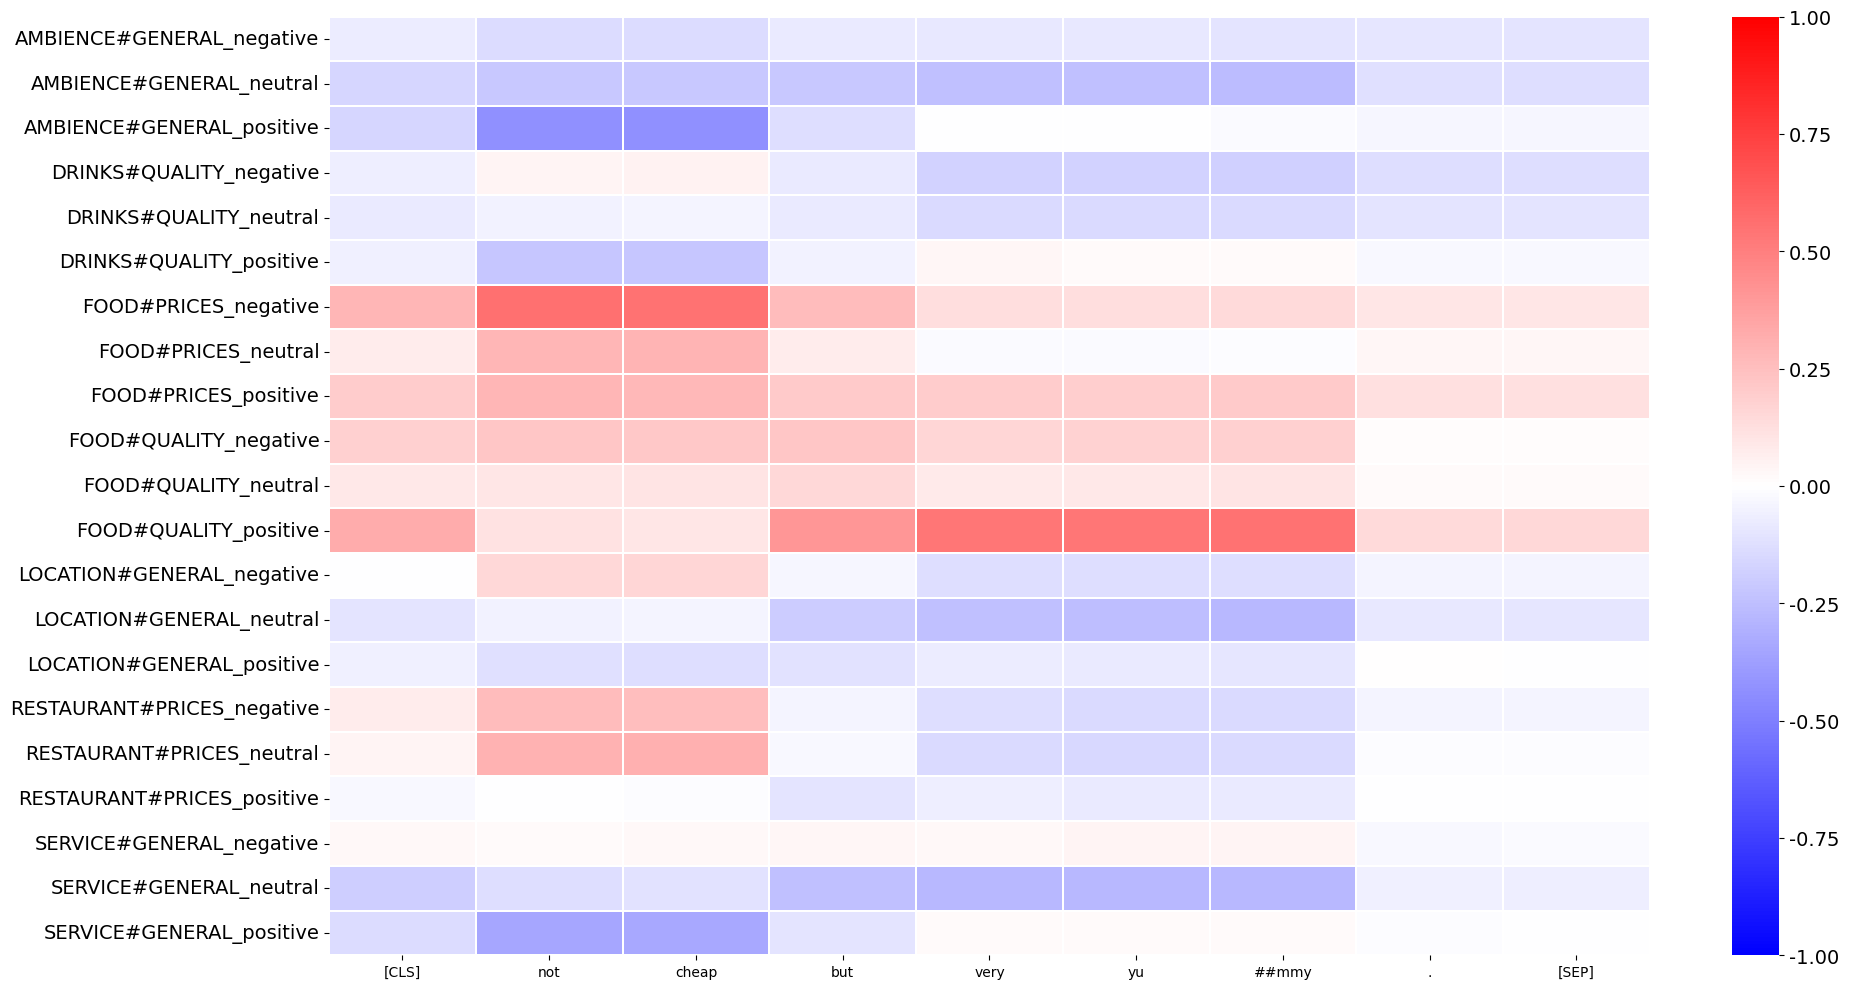

In [7]:
def get_model_output(context, infer_func, tokenizer):
    data = tokenizer.tokenize(context, aspect_texts=None)
    inputs = [data['input_ids'], data['token_type_ids'], data['attention_mask']]
    aspect_inputs = [data['aspect_input_ids'], data['aspect_token_type_ids'], data['aspect_attention_mask']]
    cache_text_states = tf.zeros((tf.shape(inputs[0])[0], tf.shape(inputs[0])[1], 768))
    output = infer_func(inputs, aspect_inputs, cache_text_states, None, phase="test", asp_senti_batch_idx=0, output_attentions=True)
    return output

def draw_sim_matrix_local(context, aspect, infer_func, tokenizer):
    output = get_model_output(context, infer_func, tokenizer)
    sim_matrix = -1 * np.array(output['sim_matrix']).squeeze()
    key_inputs = tokenizer.tokenizer.tokenize(context[0], add_special_tokens=True)
    query_inputs = []
    categoires = [each for each in RES1516_LABEL_MAPPING["category2index"]]
    sentiments = [each for each in SENTIMENT_LABEL_MAPPING]
    for asp in categoires:
        for senti in sentiments:
            query_inputs.append(asp + "_" + senti)
    
    aspect_idx = 3 * np.array([categoires.index(asp) for asp in aspect[0]])
    aspect_idx = np.sort(np.concatenate([aspect_idx, aspect_idx + 1, aspect_idx + 2]))
    
    df = pd.DataFrame(sim_matrix[aspect_idx, :len(key_inputs)])
    df.index = np.array(query_inputs)[aspect_idx]
    df.columns = key_inputs
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.figure(figsize=(20, 10))
    sns.heatmap(df, linewidths = 0.1, vmax=1, vmin=-1, cmap="bwr")
    # plt.title("Cosine Simlarity in FuseBlock")
    plt.tight_layout()
    # plt.savefig('./plots/fusebock_sim_matrix_cn_all_3t.jpg', dpi=300)
    # plt.show()
    return output
    
context = [
    # "the product is great, but the customer support is horrible"
    #  "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
    # "Yum!"
    # "– We were treated very rudely here one time for breakfast."
    "Not cheap but very yummy."
]

aspect_texts = [
    # ["BATTERY#QUALITY", "LAPTOP#PRICE", "LAPTOP#GENERAL", "COMPANY#PRICE", "SUPPORT#GENERAL", "OS#USABILITY", "SOFTWARE#GENERAL"]
    # ["BATTERY#QUALITY", "LAPTOP#GENERAL", "COMPANY#PRICE", "SUPPORT#GENERAL", "SOFTWARE#GENERAL"]
    ["AMBIENCE#GENERAL", "DRINKS#QUALITY", "FOOD#PRICES", "FOOD#QUALITY", "LOCATION#GENERAL", "RESTAURANT#PRICES", "SERVICE#GENERAL"]
    # ["AMBIENCE#GENERAL", "FOOD#QUALITY", "LOCATION#GENERAL", "RESTAURANT#PRICES", "SERVICE#GENERAL"]
]

res = draw_sim_matrix_local(context, aspect_texts, test_func, test_tokenizer)
plt.savefig('./case_study/restaurant_heatmap_implicit', dpi=300)
plt.show()
# print(res)

In [6]:
context = [
    # "Yum!",
    # "– We were treated very rudely here one time for breakfast.",
    # "I will not go back."
    "Not cheap but very yummy."
]
model_output = get_model_output(context, test_func, test_tokenizer)
tokenized_texts = tokenizer(context, padding='longest', return_offsets_mapping=True)
batch_res = Result(tokenizer).get_result(model_output, tokenized_texts, context, label_mappings=RES1516_LABEL_MAPPING,
                                                          result_type=model_type, tagging_schema='BIO')
batch_res

[[{"target": "NULL", "aspect": "FOOD#PRICES", "polarity": "negative", "prob": -1},
  {"target": "NULL", "aspect": "FOOD#QUALITY", "polarity": "positive", "prob": -1}]]

In [ ]:
test_data = [
    "the actor is skillful"
]

aspect_texts = [
    ["actor negative","actor positive"]
]
data = test_tokenizer.tokenize(test_data, aspect_texts=aspect_texts)
inputs = [data['input_ids'], data['token_type_ids'], data['attention_mask']]
aspect_inputs = [data['aspect_input_ids'], data['aspect_token_type_ids'], data['aspect_attention_mask']]
output = test_func(inputs, aspect_inputs, phase="dynamic_aspect_test", output_attentions=True)
output

In [10]:
test_data = {"text": ["The apple juice is good, i like it"],
        "language": "en",
        "output_attentions": False,
}
res = requests.post(url, json=test_data)
res.json()

{'origin_text': ['The apple juice is good, i like it'],
 'result': [[{'target': 'apple juice',
    'aspect': 'FOOD#QUALITY',
    'polarity': 'positive',
    'prob': 0.986777126789093}]],
 'time_cost': 0.30402159690856934,
 'status': 'success',
 'error_code': 0}

In [3]:
cn_init_dir = '../models/bert-base-chinese'
cn_init_model = 'bert-base-chinese'

en_init_dir = '../models/bert-base-cased'
en_init_model = 'bert-base-cased'
cn_tokenizer = AutoTokenizer.from_pretrained(cn_init_model, cache_dir=cn_init_dir)
en_tokenizer = AutoTokenizer.from_pretrained(en_init_model, cache_dir=en_init_dir)

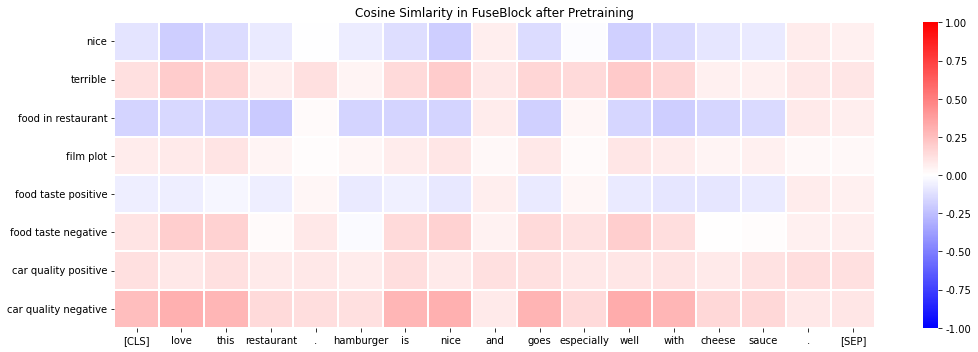

[[ 6.550733  -5.474408   7.393637  -5.865502   3.3800287 -5.494273
  -4.665544  -7.12855  ]]


In [17]:
def draw_sim_matrix_dynamic(context, aspect, infer_func, tokenizer):
    data = tokenizer.tokenize(context, aspect_texts=aspect)
    inputs = [data['input_ids'], data['token_type_ids'], data['attention_mask']]
    aspect_inputs = [data['aspect_input_ids'], data['aspect_token_type_ids'], data['aspect_attention_mask']]
    output = infer_func(inputs, aspect_inputs, phase="dynamic_aspect_test", output_attentions=True)
    sim_matrix = np.array(output['sim_matrix']).squeeze()
    key_inputs = tokenizer.tokenizer.tokenize(context[0], add_special_tokens=True)
    query_inputs = aspect[0]
    df = pd.DataFrame(sim_matrix[:, :len(key_inputs)])
    df.index = query_inputs
    df.columns = key_inputs
    plt.figure(figsize=(15, 5))
    sns.heatmap(df, linewidths = 0.1, vmax=1, vmin=-1, cmap="bwr")
    plt.title("Cosine Simlarity in FuseBlock after Pretraining")
    plt.tight_layout()
    # plt.savefig('./plots/fusebock_sim_matrix_cn_all_3t.jpg', dpi=300)
    # plt.show()
    return output["output_cls_states"].numpy()
    
context = [
    "Love this restaurant. Hamburger is nice and goes especially well with cheese sauce."
    # "curry is a basketball player, he is good at shooting three points"
]

aspect_texts = [
    # ["", "terrible", "food", "book plot", "food taste positive", "food taste negative", "car quality positive", "car quality negative"]
    ["nice", "terrible", "food in restaurant", "film plot", "food taste positive", "food taste negative", "car quality positive", "car quality negative"]
    # ["food", "food negative", "film", "story positive"]
    # ["sports", "athlete", "basketball", "player"]
]
res = draw_sim_matrix_dynamic(context, aspect_texts, test_func, test_tokenizer)
plt.savefig('../TTEE_output/images/pretrain_sim_matrix_reverse.jpg', dpi=300)
plt.show()
print(res)


In [5]:
(1 / (1 + np.exp(-res)))

array([[0.51468176, 0.51468176, 0.51468176, 0.51468176, 0.51468176]],
      dtype=float32)

In [4]:
def draw_sim_matrix(text, language):
    
    test_data = {
        "text": text,
        "output_attentions": True,
        "language": language
    }
    
    if language == "cn":
        key_inputs = cn_tokenizer.tokenize(test_data["text"][0], add_special_tokens=True)
    else:
        key_inputs = en_tokenizer.tokenize(test_data["text"][0], add_special_tokens=True)       
        
    res = requests.post(url, json=test_data).json()    
    query_inputs = []
    
    c2l = CATEGORY_LABEL_MAPPING_CHINESE if language == "cn" else CATEGORY_LABEL_MAPPING
    s2l = SENTIMENT_LABEL_MAPPING_CHINESE if language == "cn" else SENTIMENT_LABEL_MAPPING
    for asp in c2l:
        for senti in s2l:
            query_inputs.append(asp + "_" + senti)

    sim_matrix = np.array(res['attentions']).squeeze()

    df = pd.DataFrame(sim_matrix[:, :len(key_inputs)])
    df.index = query_inputs
    df.columns = key_inputs
    plt.figure(figsize=(20, 10))
    sns.heatmap(df, linewidths = 0.1, vmax=1, vmin=-1, cmap="bwr")
    plt.title("Cosine Simlarity in FuseBlock")
    plt.tight_layout()
    # plt.savefig('./plots/fusebock_sim_matrix_cn_all_3t.jpg', dpi=300)
    plt.show()

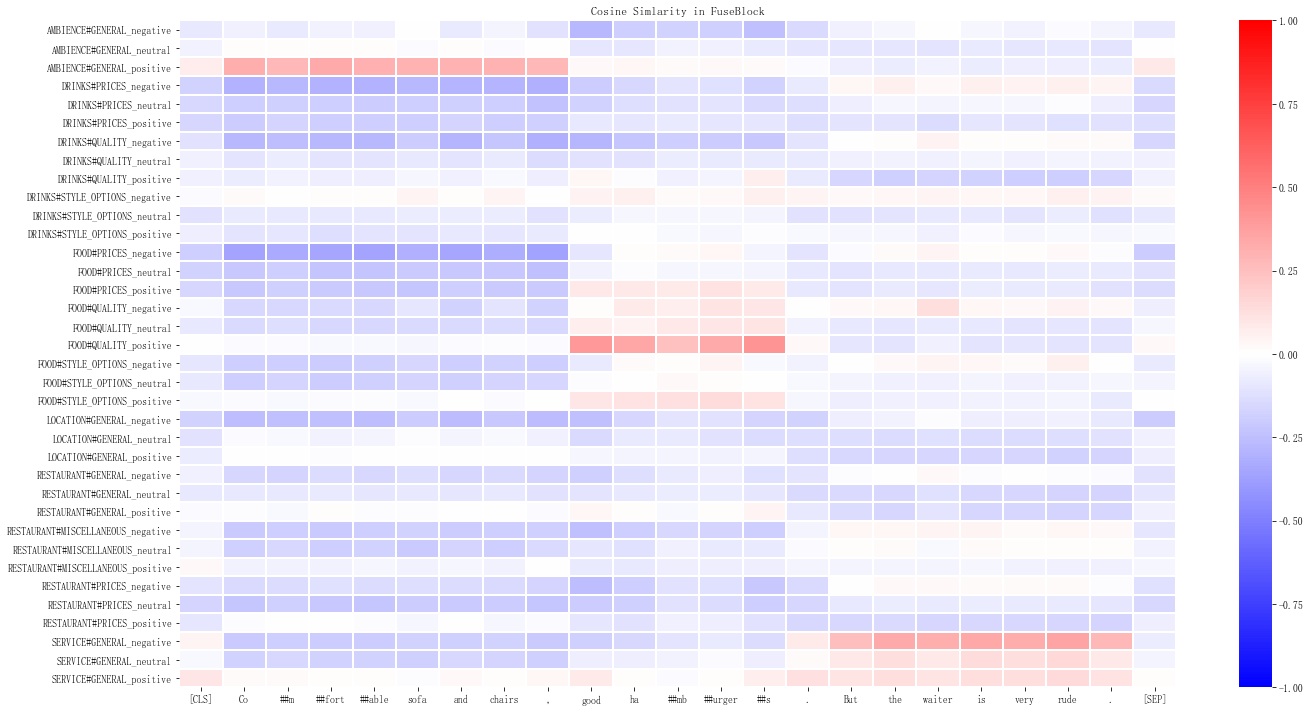

In [11]:
text =  [
#     "屏幕质量不错，很抗摔；电池续航很好，可以待机两天；相机不是很给力，拍出来有点模糊",
    "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
]
language = "en"
draw_sim_matrix(text, language)